In [3]:
import keras
import keras.layers as layers
import keras.activations as activations
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import transformations

Using TensorFlow backend.


In [4]:
X_test = np.load('X_test.npy')
X_train = np.load('X_train.npy')
y_train = np.load('Y_train.npy')

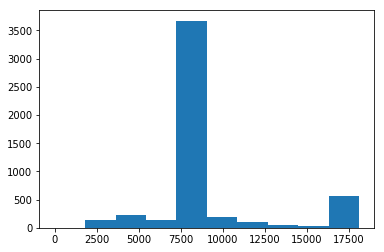

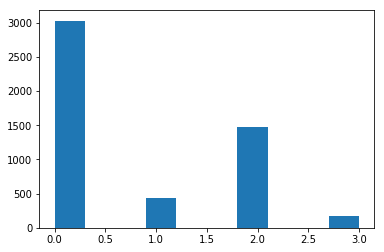

In [5]:
plt.hist(np.isnan(X_train).argmax(axis=1)) # Sequence length distribution
plt.figure()
plt.hist(y_train[:, 1]); # Class distribution

In [6]:
# Add channel dimension
X_train = X_train[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]

# Convert to one-hot
y_train = keras.utils.to_categorical(y_train[:, 1])

# Create validations set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [31]:
def feed(X, y, training=True, shorten=False, batch_size=128, spectrogram=False):
    seqlens = np.isnan(X[:,:,0]).argmax(axis=1)
    seqlens[seqlens == 0] = X.shape[1]
    target_len = seqlens.min()
    print('Shortening to %d' % target_len)
    
    # Loop over epochs
    while True:
        idx = np.arange(X.shape[0])
        
        if training:
            np.random.shuffle(idx)
                
        # Loop over batches
        for k in range(0, X.shape[0], batch_size):        
            X_batch, y_batch = [], []

            # Loop over examples
            for j in range(k, min(X.shape[0], k+batch_size)):
                i = idx[j]
                example = np.copy(X[i])
                seqlen = seqlens[i]

                if training:
                    while True:
                        # Randomly rescale
                        example = transformations.random_resample(example[np.newaxis,:seqlen,0]).T
                        seqlen = np.isnan(example).argmax()
                        if seqlen == 0: seqlen = example.shape[0]
                        if seqlen >= target_len: break
                        example = np.copy(X[i])
                        seqlen = seqlens[i]
                        
                    # Randomly set runs to zero
                    for _ in range(int(seqlens[i] / X.shape[1] * 50)):
                        blen = np.random.randint(50, 250)
                        pos = np.random.randint(seqlens[i]-blen)
                        example[pos:pos+blen] = 0

                if training and not shorten:
                    # Repeat sequence to fill padding
                    example = np.tile(example[:seqlen], [int(np.ceil(X.shape[1] / seqlen)),1])
                    example = example[:X.shape[1]]
                elif training and shorten:
                    # Choose random window to shorten sequence
                    offset = np.random.randint(seqlen - target_len + 1)
                    example = example[offset:offset+target_len]

                if spectrogram:
                    # Convert into spectrogram
                    example = transformations.spectrogram(example[np.newaxis,:seqlen,0], 64)[0,:,:,np.newaxis]
                    
                X_batch.append(example)
                
                if y is not None:
                    y_batch.append(y[i])
                
            if y is not None:
                yield np.array(X_batch), np.array(y_batch)
            else:
                yield np.array(X_batch)

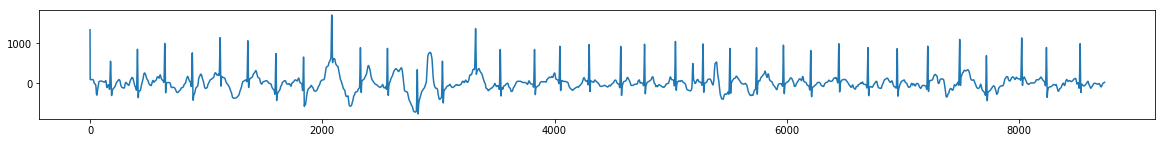

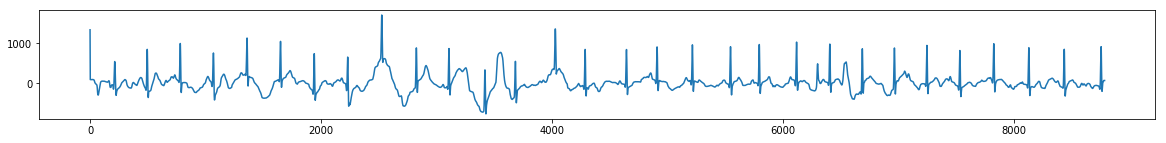

In [32]:
plt.figure(figsize=(20,2))
plt.plot(X_train[456,:,0])

res = transformations.random_resample(X_train[456,:8783,0][np.newaxis,:])
plt.figure(figsize=(20,2))
plt.plot(res[0]);

Shortening to 2606
(128, 53, 33, 1)


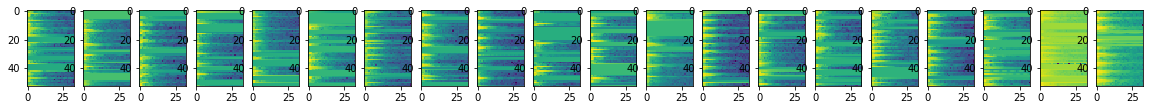

In [38]:
it = feed(X_train, Y_train, training=True, shorten=True, spectrogram=True)
print(next(it)[0].shape)
plt.figure(figsize=(20, 5))
examples = [next(it)[0][0] for _ in range(20)],
for i in range(20):
    plt.subplot(1, 20, i+1)
    if len(examples[0][0].shape) == 2:
        plt.plot(examples)
    else:
        plt.imshow(examples[0][i][:,:,0])

In [40]:
model = keras.models.Sequential()
# model.add(layers.Dropout(.5, input_shape=(None, 33, 1)))

for _ in range(3):
    model.add(layers.Conv2D(64, 3, padding='same', input_shape=(None, 33, 1)))
    model.add(layers.Conv2D(64, 3, padding='same'))
    model.add(layers.Conv2D(64, 3, padding='same'))
    model.add(layers.Activation('relu'))
    model.add(keras.layers.normalization.BatchNormalization())
    
    # Maxpool over time only
    model.add(layers.Reshape((-1, 33*64)))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Reshape((-1, 33, 64)))

# Global maxpool over time only
model.add(layers.Reshape((-1, 33*64)))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(2048, activation='relu'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [41]:
# class Metrics(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         val_predict = model.predict(X_val).argmax(axis=1)
#         val_targ = Y_val.argmax(axis=1)
#         print("f1: %.3f" % f1_score(val_targ, val_predict, average='micro'))

model.fit_generator(feed(X_train, Y_train, shorten=True, spectrogram=True), 
                    steps_per_epoch=np.ceil(X_train.shape[0]/128), 
                    epochs=4000,
                    validation_data=feed(X_val, Y_val, shorten=True, batch_size=1, spectrogram=True, training=False), 
                    validation_steps=X_val.shape[0],
                    callbacks=[
                        keras.callbacks.EarlyStopping(monitor='val_acc', patience=50, restore_best_weights=True)
                    ])

Epoch 1/4000
Shortening to 2863
Shortening to 2606
36/36 [==============================] - 21s 591ms/step - loss: 1.7143 - acc: 0.5056 - val_loss: 4.2974 - val_acc: 0.6016
Epoch 2/4000
36/36 [==============================] - 10s 272ms/step - loss: 1.5038 - acc: 0.5657 - val_loss: 6.4535 - val_acc: 0.5996
Epoch 3/4000
36/36 [==============================] - 10s 278ms/step - loss: 1.4817 - acc: 0.5741 - val_loss: 1.3624 - val_acc: 0.5996
Epoch 4/4000
36/36 [==============================] - 11s 292ms/step - loss: 1.3590 - acc: 0.5885 - val_loss: 1.2977 - val_acc: 0.6270
Epoch 5/4000
36/36 [==============================] - 11s 292ms/step - loss: 1.3976 - acc: 0.5755 - val_loss: 1.0585 - val_acc: 0.6230
Epoch 6/4000
36/36 [==============================] - 11s 292ms/step - loss: 1.4712 - acc: 0.5848 - val_loss: 0.9591 - val_acc: 0.6328
Epoch 7/4000
36/36 [==============================] - 11s 293ms/step - loss: 1.2850 - acc: 0.6030 - val_loss: 1.0453 - val_acc: 0.6191
Epoch 8/4000
36/3

36/36 [==============================] - 10s 289ms/step - loss: 0.7612 - acc: 0.6693 - val_loss: 0.9311 - val_acc: 0.5469
Epoch 62/4000
36/36 [==============================] - 11s 293ms/step - loss: 0.7555 - acc: 0.6803 - val_loss: 0.7426 - val_acc: 0.6816
Epoch 63/4000
36/36 [==============================] - 11s 295ms/step - loss: 0.7648 - acc: 0.6641 - val_loss: 0.7163 - val_acc: 0.7031
Epoch 64/4000
36/36 [==============================] - 11s 296ms/step - loss: 0.7607 - acc: 0.6702 - val_loss: 1.0214 - val_acc: 0.5859
Epoch 65/4000
36/36 [==============================] - 11s 293ms/step - loss: 0.7644 - acc: 0.6745 - val_loss: 0.8146 - val_acc: 0.6152
Epoch 66/4000
36/36 [==============================] - 11s 296ms/step - loss: 0.7501 - acc: 0.6760 - val_loss: 0.7102 - val_acc: 0.7227
Epoch 67/4000
36/36 [==============================] - 11s 293ms/step - loss: 0.7472 - acc: 0.6777 - val_loss: 0.6739 - val_acc: 0.7480
Epoch 68/4000
36/36 [==============================] - 10s 288

Epoch 181/4000
36/36 [==============================] - 11s 295ms/step - loss: 0.6787 - acc: 0.7194 - val_loss: 0.6260 - val_acc: 0.7676
Epoch 182/4000
36/36 [==============================] - 11s 293ms/step - loss: 0.6709 - acc: 0.7133 - val_loss: 0.6106 - val_acc: 0.7695
Epoch 183/4000
36/36 [==============================] - 11s 294ms/step - loss: 0.6754 - acc: 0.7125 - val_loss: 0.5503 - val_acc: 0.8008
Epoch 184/4000
36/36 [==============================] - 11s 295ms/step - loss: 0.6724 - acc: 0.7186 - val_loss: 0.6442 - val_acc: 0.7520
Epoch 185/4000
36/36 [==============================] - 11s 298ms/step - loss: 0.6607 - acc: 0.7271 - val_loss: 0.8211 - val_acc: 0.6699
Epoch 186/4000
36/36 [==============================] - 11s 298ms/step - loss: 0.6545 - acc: 0.7184 - val_loss: 0.6317 - val_acc: 0.7461
Epoch 187/4000
36/36 [==============================] - 11s 295ms/step - loss: 0.6816 - acc: 0.7121 - val_loss: 0.6038 - val_acc: 0.7617
Epoch 188/4000
36/36 [===================

In [43]:
# Evaluate
model.evaluate_generator(feed(X_val, Y_val, shorten=True, batch_size=1, spectrogram=True, training=False), 
                         steps=X_val.shape[0])

Shortening to 2863


[0.5256667150210887, 0.806640625]

In [48]:
# Predict
y_test = model.predict_generator(feed(X_test, None, training=False, spectrogram=True, batch_size=1), 
                                 steps=X_test.shape[0])
assert y_test.shape[0] == X_test.shape[0]
np.savetxt("Y_test.csv", np.stack(( np.arange(X_test.shape[0]), y_test.argmax(axis=1) ), axis=1), 
           delimiter=",", header="id,y", fmt='%d', comments='')

Shortening to 2665


In [47]:
X_test.shape

(3411, 18155, 1)

All results after 10 epochs of training, unless otherwise stated

32 filters, no maxpooling, global avgpooling:
    acc: 0.6499 val_acc: 0.5801
64 filters, maxpooling, global avgpooling:
    acc: 0.703  val_acc: 0.4570
64 filters, maxpooling, global avgpooling, run dropout: 
    acc: 0.6844 val_acc: 0.6035; 0.433
64 filters, maxpooling, global maxpooling, run dropout: 
    acc: 0.6083 val_acc: 0.6309; 0.612
64 filters, maxpooling, LSTM, run dropout:
    acc: 0.5908 val_acc: 0.4883; 0.596
64 filters, maxpooling, global maxpooling, run dropout, shortened sequences:
    acc: 0.6725 val_acc: 0.6230
64 filters, maxpooling, global maxpooling, run dropout, shortened sequences of varying len: